In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pandas import np
from tensorflow_examples.lite.model_maker.core.task.model_spec import (mobilenet_v2_spec)

assert tf.__version__.startswith('2')

import os
from pathlib import Path
from shutil import copyfile

import tensorflow as tf
from tflite_model_maker import configs
from tflite_model_maker.core.task import image_classifier

assert tf.__version__.startswith('2')
from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader


EYE_PREPARE_FOLDER = './eyes_state'
OUTPUT_MODELS_FOLDER = './model-files/'
URL_DATASET = 'http://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip'


/Users/igla/PycharmProjects/DrowsinessClassification/venv/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.4.0-dev20200810). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

### Prepare dataset

In [3]:
def prepare_dataset(filename):
    data_root = os.path.abspath(filename)
    label_names = sorted(
        name for name in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, name)))

    for index, name in enumerate(label_names):
        print(name)

    closed = []
    opened = []
    for subdir, dirs, files in os.walk(data_root):
        for file in files:
            if file.endswith('.png'):
                filename = os.path.join(subdir, file)
                eye_state = file.split('_')[4]  # '_'.join(file.split('_')[:-3])
                if eye_state == '0':
                    closed.append(filename)
                else:
                    opened.append(filename)
                # print(filename_new)

    Path(EYE_PREPARE_FOLDER).mkdir(parents=True, exist_ok=True)
    Path(f"{EYE_PREPARE_FOLDER}/opened").mkdir(parents=True, exist_ok=True)
    Path(f"{EYE_PREPARE_FOLDER}/closed").mkdir(parents=True, exist_ok=True)

    for file in opened:
        copyfile(file, f"{EYE_PREPARE_FOLDER}/opened/" + os.path.basename(file))
    for file in closed:
        copyfile(file, f"{EYE_PREPARE_FOLDER}/closed/" + os.path.basename(file))

zip_file = tf.keras.utils.get_file(
      'eye_photos.zip',
      URL_DATASET, extract=True)
base_dir = os.path.join(os.path.dirname(zip_file), 'mrlEyes_2018_01')
print(base_dir)
prepare_dataset(base_dir)

In [4]:
data = ImageClassifierDataLoader.from_folder(EYE_PREPARE_FOLDER)
#train_data, test_data = data.split(0.9)

train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)


INFO:tensorflow:Load image with size: 84898, num_label: 2, labels: closed, opened.


Show 25 image examples

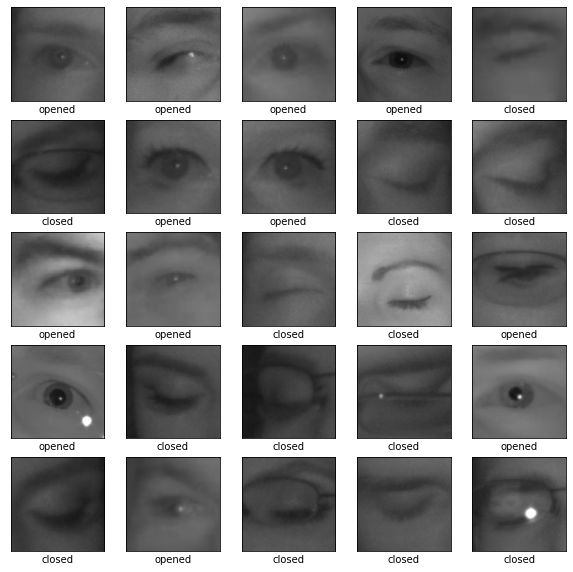

In [5]:
# Show 25 image examples with labels.
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(data.dataset.take(25)):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)
    plt.xlabel(data.index_to_label[label.numpy()])
plt.show()


In [ ]:
# Customize the TensorFlow model.
model = image_classifier.create(data, epochs=5, model_spec=mobilenet_v2_spec, validation_data=validation_data)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/5
2653/2653 [==============================] - 1631s 615ms/step - loss: 0.3228 - accuracy: 0.9408 - val_loss: 0.2688 - val_accuracy: 0.9697

Have a look at the detailed model structure.

In [ ]:
# Have a look at the detailed model structure.
print('Summary!')
model.summary()

print('Plot history!')
print(model.history.history)
# summarize history for accuracy
history = model.history
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluate the model.

In [ ]:
# Evaluate the model.
final_loss, final_accuracy = model.evaluate(test_data)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
    if val1 == val2:
        return 'black'
    else:
        return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    predict_label = predicts[i][0][0]
    color = get_label_color(predict_label,
                            test_data.index_to_label[label.numpy()])
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()


### Export TFLite Floating model and label file

In [ ]:
Path(OUTPUT_MODELS_FOLDER).mkdir(parents=True, exist_ok=True)

# Export to Tensorflow Lite model and label file in `export_dir`.
model.export(export_dir=OUTPUT_MODELS_FOLDER, tflite_filename='eyes_float.tflite', label_filename='eyes_labels.txt')
float_accuracy = model.evaluate_tflite(f"{OUTPUT_MODELS_FOLDER}eyes_float.tflite", test_data)
print(f'Float accuracy {float_accuracy}')

### Export TFLite Quantized model and label file

In [ ]:
# Quant
config = configs.QuantizationConfig.create_full_integer_quantization(representative_data=test_data,
                                                                     is_integer_only=True)
model.export(export_dir=OUTPUT_MODELS_FOLDER, tflite_filename='eyes_quant.tflite', label_filename='eyes_labels2.txt',
             quantization_config=config)
quant_accuracy = model.evaluate_tflite(f"{OUTPUT_MODELS_FOLDER}eyes_quant.tflite", test_data)
print(f'Quant accuracy {quant_accuracy}')


### Run predictions on each test image data and calculate accuracy.

In [ ]:
interpreter = tf.lite.Interpreter(
    model_path=f"{OUTPUT_MODELS_FOLDER}eyes_float.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

dataset_labels = ['closed', 'opened']
# Run predictions on each test image data and calculate accuracy.
accurate_count = 0
for i, (image, label) in enumerate(test_data.dataset):
    # Pre-processing should remain the same. Currently, just normalize each pixel value and resize image according to the model's specification.
    image, _ = model.preprocess(image, label)
    # Add batch dimension and convert to float32 to match with the model's input
    # data format.
    image = tf.expand_dims(image, 0).numpy()

    # Run inference.
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Convert prediction results to Pandas dataframe, for better visualization
    tflite_pred_dataframe = pd.DataFrame(output_data)
    tflite_pred_dataframe.columns = dataset_labels

    print("TFLite prediction results for the first elements")
    tflite_pred_dataframe.head()

    # Post-processing: remove batch dimension and find the label with highest
    # probability.
    predict_label = np.argmax(output_data[0])
    # Get label name with label index.
    predict_label_name = dataset_labels[predict_label]

    accurate_count += (predict_label == label.numpy())

accuracy = accurate_count * 1.0 / test_data.size
print('TensorFlow Lite model accuracy = %.3f' % accuracy)